<h2 align=center> Facial Expression Recognition with Keras</h2>

### Task 1: Import Libraries

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import os
%matplotlib inline

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout,Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

from IPython.display import SVG, Image
from livelossplot import PlotLossesKeras
from livelossplot.keras import PlotLossesCallback
import tensorflow as tf
print("Tensorflow version:", tf.__version__)

### Task 2: Plot Sample Image

In [ ]:
utils.datasets.fer.plot_example_images(plt).show()

In [ ]:
for expression in os.listdir("train/"):
    print(str(len(os.listdir("train/"+ expression)))+ " "+ expression+ " images")

### Task 3: Generate Training and Validation Batches

In [ ]:
img_size = 48
batch_size= 64

datagen_train= ImageDataGenerator(horizontal_flip = True)
train_generator = datagen_train.flow_from_directory("train/", 
                                                    target_size=(img_size, img_size),
                                                    color_mode ="grayscale",
                                                    batch_size= batch_size,
                                                    class_mode = "categorical",
                                                   shuffle= True)

datagen_validation= ImageDataGenerator(horizontal_flip = True)
validation_generator = datagen_train.flow_from_directory("test/", 
                                                    target_size=(img_size, img_size),
                                                    color_mode ="grayscale",
                                                    batch_size= batch_size,
                                                    class_mode = "categorical",
                                                   shuffle= True)

### Task 4: Create CNN Model

![](model.png)
Inspired by Goodfellow, I.J., et.al. (2013). Challenged in representation learning: A report of three machine learning contests. *Neural Networks*, 64, 59-63. [doi:10.1016/j.neunet.2014.09.005](https://arxiv.org/pdf/1307.0414.pdf)

In [ ]:
model =Sequential()

#1st layer
model.add(Conv2D(64,(3,3), padding ="same", input_shape=(48,48,1)))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.8))

#2nd layer
model.add(Conv2D(128,(5,5), padding ="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

#3rd layer
model.add(Conv2D(512,(3,3), padding ="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

#4th layer
model.add(Conv2D(512,(3,3), padding ="same"))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size= (2,2)))
model.add(Dropout(0.25))

model.add(Flatten())

#1st fully connected layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

#2nd fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation("relu"))
model.add(Dropout(0.25))

#output layer
model.add(Dense(7, activation= "softmax"))
opt= Adam(lr= 0.0005)

model.compile(optimizer=opt, loss="categorical_crossentropy", metrics= ['accuracy'])
model.summary()


### Task 6: Train and Evaluate Model

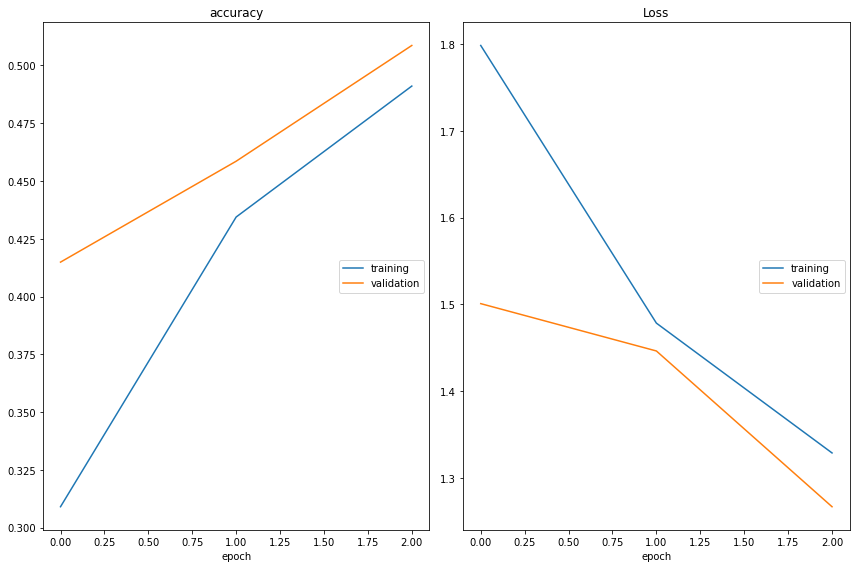

accuracy
	training         	 (min:    0.309, max:    0.491, cur:    0.491)
	validation       	 (min:    0.415, max:    0.509, cur:    0.509)
Loss
	training         	 (min:    1.329, max:    1.798, cur:    1.329)
	validation       	 (min:    1.267, max:    1.501, cur:    1.267)

Epoch 00003: saving model to model_weights.h5
448/448 [==============================] - 747s 2s/step - loss: 1.3291 - accuracy: 0.4911 - val_loss: 1.2671 - val_accuracy: 0.5086 - lr: 5.0000e-04
Epoch 4/15
 42/448 [=>............................] - ETA: 8:57 - loss: 1.2537 - accuracy: 0.5201

In [ ]:
epochs= 15
steps_per_epoch = train_generator.n//train_generator.batch_size
validation_steps =validation_generator.n//validation_generator.batch_size

checkpoint = ModelCheckpoint("model_weights.h5", monitor="val_accuracy",
                            save_weights_only= True, mode = "max", verbose =1)
reduce_lr = ReduceLROnPlateau(monitor= "val_loss", factor=0.1, patience=2, min_lr=0.0000, model="auto")

callbacks=[PlotLossesKeras(), checkpoint, reduce_lr]
history = model.fit(
    x= train_generator,
    steps_per_epoch =steps_per_epoch,
    epochs=epochs,
    validation_data= validation_generator,
    validation_steps = validation_steps,
    callbacks= callbacks
)


### Task 7: Improve Accuracy of the model

In [ ]:

param_distribs = {
"n_hidden": [0, 1, 2, 3,4,5,6,7,8],
"n_neurons": np.arange(1, 600),
"learning_rate": reciprocal(3e-4, 3e-2),
"epochs": np.arange(15, 120),
}
rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10,
cv=3)
rnd_search_cv.fit(X_train, y_train, epochs=100,
validation_data=(X_valid, y_valid),
callbacks=[keras.callbacks.EarlyStopping(patience=10)])


### Task 8: Represent Model as JSON String

In [9]:
model_json =model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
